# **Group 1**
## **RQ**

## ***Disclaimer!***
This notebook is meant xxx. To access the Quick, Draw! as well as the oracle bone script datasets, please go to this [Google Drive Folder](https://drive.google.com/drive/folders/1nJxpzrK6MH4BcW7mo2ADEWFEh0lQE-np?usp=share_link) and add the folder to your own Google Drive. By clicking on the folder name "DLiP_Group1" and selecting "Add a shortcut to Drive", all necessary files are automatically shared with your main Drive environment without having to download all the data or files individually! After that, simply run all the code as you like.

### ***Tabel of contents***

1. **Introduction**
2. **Methods: Data, Model, and Fitting**
3. **Results and Analyses**
4. **Discussion and Concluding Remarks**

### ***Background***
The aim of this project is to train a neural network on recognizing different landscapes and objects associated with them by classifying satellite images. Nowadays, various localization tasks such as urban planning or land utilization for underdeveloped regions are highly relevant and depend on the evaluation of large areas. Advanced land and object detection techniques using satellite images offer a quick and convenient tool for experts in those fields and enable them to execute their responsibilities more efficiently (Albert et al., 2017). To assist in this effort, the present project utilizes a convolutional neural network (CNN) architecture (Kadhim & Abed, 2019). As CNNs have been proven to be particularly useful for image processing and classification, the general framework of this project will revolve around building a custom classifier, however, involving pre-trained weight matrices. Considering the data source being satellite images, we were interested in applying different augmentation techniques to explore what image distortions make sense. In this context, we want to investigate a custom data augmentation method manipulating the RGB layers of images individually. Here, we are interested in comparing this model to a baseline model only utilizing recommended augmentations. Additionally, to create a generalizable model, we performed robustness analyses and tested the model on a function accessing satellite images and classifying them simultaneously.

### ***Project idea***

We are interested in figuring out to what extent the old chinese script aligns with modern doodles regarding object representation. As Chinese characters are originally based on the image of what they describe, these can be seen as a sort of ancient doodle figures. It would be interesting to find out to what degree there is overlap between the meaning of the ancient characters and objects the doodles describe.

### ***Setting up the notebook***
Before we commence the network training, standard and third party library imports are required. These include the usual data science packages (e.g., numpy, matplotlib) as well as more specialized libraries enabling the construction of neural networks (e.g., tensorflow) and image processing capabilities (e.g., PIL). Additionally, we have to define the directory from where we retrieve our resources.

In [45]:
# Import helper libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import requests
from io import BytesIO # Use When expecting bytes-like objects
import pickle
from collections import OrderedDict
import os
from os import path
import ast
import random
from pprint import pprint

# import matplotlib for visualization
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# import PIL for image manipulation
from PIL import Image, ImageDraw, ImageOps

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# import cv2 module from OpenCV
import cv2


In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load in the dataset containing the Oracle Bone labels.

In [47]:
# Bone script categories
testdat = pd.read_csv("/content/drive/MyDrive/DLiP/TESTOB_labels_EN.csv")

Select the Oracle Bone Script categories that match the categories of the QuickDraw dataset by Google.



In [41]:
# Collect all categories of the Oracle Bone Script dataset that overlap with the
# doodles of the Quickdraw dataset either semantically or visually.

unique_values = testdat['matched name'].dropna().unique()

# Print the unique values
print(unique_values)

['wine glass' 'snowflake?' 'tiger?' 'nose' 'spoon' 'river' 'horse' 'pond?'
 'flower?' 'book' 'fork' 'car' 'sun, moon, star' 'tooth' 'houseplant?'
 'house?' 'leaf' 'belt' 'knife' 'book?' 'stove?' 'cup' 'string bean'
 'tree' 'ear' 'square' 'door' 'campfire?' 'envelope' 'mountain' 'drums'
 'duck' 'pants, t-shirt?' 'axe' 'toothpaste?' 'stove' 'arm' 'house'
 'necklace?' 'sink' 'grass' 'sea turtle' 'fish' 'rainbow' 'tiger' 'teapot'
 'plant? grass?' 'pig' 'jail' 'barn' 'diamond?' 'cup?' 'deer?' 'dog?'
 'fence? jail?' 'house plant' 'tree?' 'rain' 'dragon' 'river?' 'deer'
 'river? waterslide? lol' 'dog' 'houseplant? grass?' 'eye?' 'beach?'
 'frog' 'face' 'eye? eyeglasses?' 'cow?' 'eye' 'monkey' 'bird' 'cow'
 'bathtub' 'lightning' 'feather?' 'jacket?' 'tooth?' 'sun' 'rhinoceros'
 'rabbit' 'dolphin' 'crocodile' 'elephant' 'star' 'sheep' 'campfire'
 'wine bottle' 'feather' 'pencil' 'mouth' 'moon' 'cloud' 'sword' 'elbow'
 'broom' 'helmet' 'drum' 'hammer']


In [43]:
# Make a list of all the categories that we won't use, either because they're
# not present in our QD dataset, or because they're semantically ambiguous.

# bad_cats = ['deer', 'face', 'sun, moon, star','knife', 'eye', 'star', 'sword', 'drum']

# Exclude categories with a "?" in it. These are related but not identical.
no_questions = [item for item in unique_values if not pd.Series(item).str.contains(r'\?', na=False).any()]

# Print the filtered list
# Print the filtered list excluding 'deer'
good_cats = [cat for cat in no_questions if cat not in bad_cats]

print(good_cats)

['wine glass', 'nose', 'spoon', 'river', 'horse', 'book', 'fork', 'car', 'tooth', 'leaf', 'belt', 'cup', 'string bean', 'tree', 'ear', 'square', 'door', 'envelope', 'mountain', 'drums', 'duck', 'axe', 'stove', 'arm', 'house', 'sink', 'grass', 'sea turtle', 'fish', 'rainbow', 'tiger', 'teapot', 'pig', 'jail', 'barn', 'house plant', 'rain', 'dragon', 'dog', 'frog', 'monkey', 'bird', 'cow', 'bathtub', 'lightning', 'sun', 'rhinoceros', 'rabbit', 'dolphin', 'crocodile', 'elephant', 'sheep', 'campfire', 'wine bottle', 'feather', 'pencil', 'mouth', 'moon', 'cloud', 'elbow', 'broom', 'helmet', 'hammer']


In [9]:
# Create categorie list.

# OBcats = ['sea turtle', 'bird', 'tiger', 'dragon', 'frog']
# OBcats = ['teapot', 'tiger', 'house', 'dragon', 'pig', 'frog', 'bird', 'tree', 'mountain', 'grass','tooth', 'bird', 'rain', 'jail', 'barn', 'axe', 'grass', 'stove', 'sea turtle', 'duck']
OBcats = good_cats
ncats = len(OBcats)

# Make dictionary with numbers attached.
label_dict = {i + 1: cat for i, cat in enumerate(OBcats)}

# Uncomment to see the categories to be used
# pprint(label_dict)

Here we take a look at the Chinese characters in our datafile.

In [10]:
# Get the values in the chinese character column corresponding with the good_cats
filtered_names = testdat.loc[testdat['matched name'].isin(good_cats), 'name']

# As you can see, these are a lot more than the categories we use.
# This is because we used ".isin", so all values that contain the strings are also
# included, even if they don't perfectly match.
# In addition, there are some categories that have multiple characters
print(filtered_names.unique())

['白' '鼻' '匕' '濞' '驳' '册' '叉' '车' '齿' '朿' '带' '斗' '豆' '杜' '耳' '方' '扉' '封'
 '夆' '缶' '凫' '斧' '鬲' '肱' '宫' '鼓' '盥' '雚' '龟' '鲧' '虹' '虍' '壶' '虎' '户' '淮'
 '鸡' '家' '豭' '监' '京' '李' '栎' '砅' '蒚' '霖' '龙' '马' '尨' '门' '黾' '木' '艿' '柰'
 '猱' '鸟' '牛' '盆' '戚' '霋' '杞' '犬' '雀' '日' '桑' '山' '杉' '豕' '室' '书' '汜' '兕'
 '梌' '兔' '豚' '乇' '鼍' '象' '畜' '甗' '焱' '燕' '羊' '卣' '盂' '鱼' '羽' '雨' '聿' '曰'
 '月' '戉' '岳' '云' '栽' '宅' '翟' '彘' '雉' '洀' '肘' '帚' '冑' '竹' '隹' '椎' '尊']


As this **filtered_names** object doesn't provide information on the relation of these characters with our categories, we'll create some dictionaries that do.

In [11]:
# Initialize an empty dictionary
id_fullmatch = {}

# Iterate over all categories.
for cat in OBcats:
    # Get the indices where the current value is present
    indices = testdat.index[testdat['matched name'] == cat].tolist()

    # Create dictionary with unfiltered categories and corresponding indices.
    id_fullmatch[cat] = indices

# Make a list for the values in the dictionary.
filter_vals = list(id_fullmatch.values())

# Uncomment to see the corresponding indices with the chinese characters for
# each category we're interested in.
# pprint(id_fullmatch)

Good, now we have the indices to couple the Chinese characters and the categories. Let's do that:

In [12]:
# Create dictionary with all OBcats and the unique corresponding Chinese characters.
chin_dict = {}
for fm_cat in range(len(filter_vals)):
    category = OBcats[fm_cat]
    names = list(testdat['name'][filter_vals[fm_cat]])
    unique_names = list(set(names))  # Convert to set to remove duplicates, then back to list
    chin_dict[category] = unique_names

pprint(chin_dict)

{'arm': ['肱'],
 'axe': ['斧', '戉', '戚'],
 'barn': ['京'],
 'bathtub': ['盆'],
 'belt': ['带'],
 'bird': ['雀', '隹', '鸟', '翟', '燕', '雉'],
 'book': ['书', '册'],
 'broom': ['帚'],
 'campfire': ['焱'],
 'car': ['车'],
 'cloud': ['云'],
 'cow': ['牛'],
 'crocodile': ['鼍'],
 'cup': ['甗', '斗'],
 'dog': ['尨', '犬'],
 'dolphin': ['豚'],
 'door': ['扉', '户', '门'],
 'dragon': ['龙'],
 'drums': ['鼓', '缶'],
 'duck': ['凫', '鸡'],
 'ear': ['耳'],
 'elbow': ['肘'],
 'elephant': ['象'],
 'envelope': ['封'],
 'feather': ['羽'],
 'fish': ['鲧', '鱼'],
 'fork': ['叉'],
 'frog': ['黾'],
 'grass': ['乇', '雚', '艿'],
 'hammer': ['椎'],
 'helmet': ['冑'],
 'horse': ['驳', '马'],
 'house': ['家', '宅', '宫', '室'],
 'house plant': ['蒚', '李'],
 'jail': ['监'],
 'leaf': ['朿'],
 'lightning': ['霋'],
 'monkey': ['猱'],
 'moon': ['月'],
 'mountain': ['岳', '夆', '山'],
 'mouth': ['曰'],
 'nose': ['鼻'],
 'pencil': ['聿'],
 'pig': ['豭', '豕', '彘'],
 'rabbit': ['兔'],
 'rain': ['雨', '霖'],
 'rainbow': ['虹'],
 'rhinoceros': ['兕', '洀'],
 'river': ['汜', '濞', '淮'],
 '

In [49]:
# for category, names in chin_dict.items():
#     print(f"Category: {category}")
#     for name in names:
        # Image.open("/content/drive/MyDrive/DLiP/mod_mand/" + name + "/1.png")
    # print("\n")  # Add a newline to separate categories

# name = str(chin_dict['wine glass'])
# print(chin_dict['wine glass'])

# fix this
# Image.open("/content/drive/MyDrive/DLiP/mod_mand/"+name+"/1.png")


In [44]:
Image.open(str(file_path))

NameError: ignored

This code loads in all the QuickDraw data. As this is a rather large dataset, it might take a while to run. This does however depend on the amount of categories you choose to use.

In [13]:
# Use same categories for the QuickDraw data

categories = OBcats

# load data for each category
classes = {}

for category in categories:
    data = pd.read_csv("/content/drive/MyDrive/DLiP/quickdraw/QD_train_total/" + category + ".csv")
    classes[category] = data

In [ ]:
# 白

# "/content/drive/MyDrive/DLiP/mod_mand/白/1.png"


Here we create some useful dictionaries to work with the imported data from the Oracle Bone dataset later on. The current format of the data is still relatively 'raw', and is completely different from how the QuickDraw images are represented. Later on we will use some functions that apply specific algorithms to the Oracle Bone images so that they are transformed into the same format.

In [18]:
# This is the code to get the data in the right format to start working with it
# It also gives you the list with the .jpg names and all together in a dictionary

picname = {}
pic = {}
pixels = {}
pic_vecs = {}

# Initialize a dictionary to store DataFrames for each category
OBdict = {}

# Initialize a dictionary to store picture names sorted per OBcategory
picname_per_cat = {}

for ind, OBcategory in enumerate(OBcats):
    # Initialize lists for pixel values for the current category
    pixels_category = []
    OBcatvec = np.array((testdat[testdat['matched name'] == OBcats[ind]])['image'])

    # Initialize list to store picture names for the current category
    picname_per_cat[OBcategory] = []

    for i in range(len(OBcatvec)):
        picname[i] = OBcatvec[i]
        picname_per_cat[OBcategory].append(picname[i])
        pic[i] = Image.open("/content/drive/MyDrive/DLiP/oracle_bone/image/" + picname[i]).convert('RGB')
        pixels[i] = [
            [list(pic[i].getdata(band=0)),
             list(pic[i].getdata(band=1))]
        ]
        pixels_category.append(pixels[i])

    # Create a Pandas DataFrame for the current category
    df_category = pd.DataFrame({'bonescript': pixels_category})

    # Add the DataFrame to the dictionary
    OBdict[OBcategory] = df_category

# Display the dictionary
for OBcategory, df_category in OBdict.items():
    print(f"\nCategory: {OBcategory}")
    print(df_category)

# Display the dictionary containing picture names sorted per OBcategory
for OBcategory, picnames in picname_per_cat.items():
    print(f"\nCategory: {OBcategory}")
    print(f"Picture Names: {picnames}")



Category: wine glass
                                          bonescript
0  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...

Category: nose
                                          bonescript
0  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...

Category: spoon
                                          bonescript
0  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...
1  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...
2  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...

Category: river
                                          bonescript
0  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...
1  [[[255, 255, 255, 255, 255, 255, 255, 255, 253...
2  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...

Category: horse
                                          bonescript
0  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...
1  [[[255, 255, 255, 255, 255, 255, 255, 255, 255...

Category: book
                                          bonescript
0  [[[255, 255, 255, 255, 255, 255, 255, 255, 2

In [ ]:
# # Inverse the image vectors.

# # Iterate over the OBdict dictionary
# for OBcategory, df_category in OBdict.items():
#     # Check if the first image in the category has all white pixels
#     if any(pixel == 255 for pixel in df_category['bonescript'][0][0]):
#         # Iterate over the 'bonescript' column in the DataFrame
#         for i in range(len(df_category['bonescript'])):
#             # Invert pixel values in the 'bonescript' column
#             inverted_pixels = [
#                 [
#                     [255 - pixel for pixel in channel]
#                     for channel in band
#                 ]
#                 for band in df_category['bonescript'][i]
#             ]
#             df_category['bonescript'][i] = inverted_pixels

# # Display the modified dictionary
# for OBcategory, df_category in OBdict.items():
#     print(f"\nCategory: {OBcategory}")
#     print(df_category)


Here we define the **image_to_lines** function, which we use to convert the Oracle Bone images into the same format as is used in the QuickDraw dataset. The black-on-white drawings are reduced to vectors that represent the strokes that make up the image. This way you don't have to represent all the trivial information in an image. However, it is important that

In [20]:
def image_to_lines(image_path, threshold=155, width=28, depth=28):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize the image to 50x50
    resized_image = cv2.resize(image, (width, depth))

    # Threshold the resized image to create a binary image
    _, binary_image = cv2.threshold(resized_image, threshold, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the binary image using list retrieval mode
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank canvas to draw contours
    lines_image = np.zeros_like(binary_image)

    # Draw contours on the blank canvas
    cv2.drawContours(lines_image, contours, -1, (255), thickness=cv2.FILLED)

    # Create a list to store stroke data
    all_strokes = []

    # Store stroke data in the list
    for contour in contours:
        x_coords = contour[:, 0, 0].tolist()
        y_coords = contour[:, 0, 1].tolist()
        all_strokes.append([x_coords, y_coords])

    # # Convert the list of strokes to a dictionary for easier handling
    # strokes_dict = {i + 1: stroke for i, stroke in enumerate(all_strokes)}

    return lines_image, all_strokes, binary_image

# # Example usage
# jpg_file_path = "/content/drive/MyDrive/DLiP/oracle_bone/image/" + picname[1]
# lines_image, _, all_strokes = image_to_lines(jpg_file_path)

# # Display the lines image
# plt.imshow(lines_image, cmap='gray')
# plt.title("Lines Image")
# plt.axis('off')
# plt.show()

# # Print the strokes dictionary
# print("Strokes Dictionary:")
# for key, value in strokes_dict.items():
#     print(f"Stroke {key}: x_coords = {value[0]}, y_coords = {value[1]}")

# print()

# # Print the list of all strokes
# print("All Strokes List:")
# for i, stroke in enumerate(all_strokes):
#     print(f"Stroke {i + 1}: x_coords = {stroke[0]}, y_coords = {stroke[1]}")


In [ ]:
# def image_to_lines(image_path, threshold=155):
#     # Read the image
#     image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#     # Resize the image to 50x50
#     resized_image = cv2.resize(image, (50, 50))

#     # Threshold the resized image to create a binary image
#     _, binary_image = cv2.threshold(resized_image, threshold, 255, cv2.THRESH_BINARY_INV)

#     # Find contours in the binary image using list retrieval mode
#     contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

#     # Create a blank canvas to draw contours
#     lines_image = np.zeros_like(binary_image)

#     # Draw contours on the blank canvas
#     cv2.drawContours(lines_image, contours, -1, (255), thickness=cv2.FILLED)

#     return lines_image

In [21]:
# CRUCIAL!!!! THis is basically all we need, took me a shit load of time

tot = 0
for OBcat in OBcats:
  for item in range(0, len(OBdict[OBcat]['bonescript'])):
    _,(OBdict[OBcat]['bonescript'][item]),_ = image_to_lines("/content/drive/MyDrive/DLiP/oracle_bone/image/" + picname_per_cat[OBcat][item])
    tot += 1

print("Total amount of images: " + str(tot))

Total amount of images: 225


Same one but this is to visualize them more easily, the ones comprised to 28x28 are difficult to plot together. Here we create a new dictionary that keeps the images at 50x50, this is purely for visualization purposes.

In [23]:
tot = 0
rs_strk = {}
for OBcat in OBcats:
  rs_strk[OBcat] = {}
for OBcat in OBcats:
  for item in range(0, len(OBdict[OBcat]['bonescript'])):
    _,rs_strk[OBcat][item],_ = image_to_lines("/content/drive/MyDrive/DLiP/oracle_bone/image/" + picname_per_cat[OBcat][item],
                              width=50, depth=50)
    tot += 1


Here we define a selection of functions to be used for the formatting of the images in our datasets.

In [24]:
def OBconvert_to_PIL(drawing, width = 51, height = 51):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """

    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()

    draw = ImageDraw.Draw(pil_img)

    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)

    return pil_img

def OBconvert_to_np_raw(drawing, width = 51, height = 51):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (28 X 28)
    """
    # initialize empty numpy array
    img = np.zeros((28, 28))

    # create a PIL image out of drawing
    pil_img = OBconvert_to_PIL(drawing)

    #resize to 28,28
    pil_img.thumbnail((28,28), Image.LANCZOS)

    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()

    # fill in numpy array with pixel values
    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 50

    return img

In [25]:
# Image manipulation utilities:

def convert_to_PIL(drawing, width = 256, height = 256):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """

    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()

    draw = ImageDraw.Draw(pil_img)

    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)

    return pil_img

def convert_to_np_raw(drawing, width = 256, height = 256):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (28 X 28)
    """
    # initialize empty numpy array
    img = np.zeros((28, 28))

    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)

    #resize to 28,28
    pil_img.thumbnail((28,28), Image.LANCZOS)

    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()

    # fill in numpy array with pixel values
    for i in range(0, 28):
        for j in range(0, 28):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

def convert_to_np(pil_img, width = 256, height = 256):
    """
    Function to convert PIL Image to numpy array.
    INPUT:
        pil_img - (PIL Image) image to be converted
    OUTPUT:
        img - (numpy array) converted image with shape (width, height)
    """
    pil_img = pil_img.convert('RGB')

    img = np.zeros((width, height))
    pixels = pil_img.load()

    for i in range(0, width):
        for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img

def view_image(img, width = 256, height = 256):
    """
    Function to view numpy image with matplotlib.
    The function saves the image as png.
    INPUT:
        img - (numpy array) image from train dataset with size (1, 784)
    OUTPUT:
        None
    """
    fig, ax = plt.subplots(figsize=(6,9))
    ax.imshow(img.reshape(width, height).squeeze())
    ax.axis('off')

    plt.show()

def crop_image(image):
    """
    Crops image (crops out white spaces).
    INPUT:
        image - PIL image of original size to be cropped
    OUTPUT:
        cropped_image - PIL image cropped to the center  and resized to (28, 28)
    """
    cropped_image = image

    # get image size
    width, height = cropped_image.size

    # get image pixels
    pixels = cropped_image.load()

    image_strokes_rows = []
    image_strokes_cols = []

    # run through the image
    for i in range(0, width):
        for j in range(0, height):
            # save coordinates of the image
            if (pixels[i,j][0] > 0):
                image_strokes_cols.append(i)
                image_strokes_rows.append(j)

    # if image is not empty then crop to contents of the image
    if (len(image_strokes_rows)) > 0:
        # find the box for image
        row_min = np.array(image_strokes_rows).min()
        row_max = np.array(image_strokes_rows).max()
        col_min = np.array(image_strokes_cols).min()
        col_max = np.array(image_strokes_cols).max()

        # find the box for cropping
        margin = min(row_min, height - row_max, col_min, width - col_max)

        # crop image
        border = (col_min, row_min, width - col_max, height - row_max)
        cropped_image = ImageOps.crop(cropped_image, border)

    # get cropped image size
    width_cropped, height_cropped = cropped_image.size

    # create square resulting image to paste cropped image into the center
    dst_im = Image.new("RGBA", (max(width_cropped, height_cropped), max(width_cropped, height_cropped)), "white")
    offset = ((max(width_cropped, height_cropped) - width_cropped) // 2, (max(width_cropped, height_cropped) - height_cropped) // 2)
    # paste to the center of a resulting image
    dst_im.paste(cropped_image, offset)

    #resize to 28,28
    dst_im.thumbnail((28,28), Image.LANCZOS)

    return dst_im

def normalize(arr):
    """
    Function performs the linear normalizarion of the array.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    INPUT:
        arr - orginal numpy array
    OUTPUT:
        arr - normalized numpy array
    """
    arr = arr.astype('float')
    # Do not touch the alpha channel
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def normalize_image(image):
    """
    Function performs the normalization of the image.
    https://stackoverflow.com/questions/7422204/intensity-normalization-of-image-using-pythonpil-speed-issues
    INPUT:
        image - PIL image to be normalized
    OUTPUT:
        new_img - PIL image normalized
    """
    arr = np.array(image)
    new_img = Image.fromarray(normalize(arr).astype('uint8'),'RGBA')
    return new_img

def rotate_image(src_im, angle = 45, size = (28,28)):
    """
    Function to rotate PIL Image file
    INPUT:
        src_im - (PIL Image) 28x28 image to be rotated
        angle - angle to rotate the image
        size - (tuple) size of the output image
    OUTPUT:
        dst_im - (PIL Image) rotated image
    """
    dst_im = Image.new("RGBA", size, "white")
    src_im = src_im.convert('RGBA')

    rot = src_im.rotate(angle)
    dst_im.paste(rot, (0, 0), rot)

    return dst_im

def flip_image(src_im):
    """
    Function to flip a PIL Image file.
    INPUT:
        scr_im - (PIL Image) image to be flipped
    OUTPUT:
        dst_im - (PIL Image) flipped image
    """
    dst_im = src_im.transpose(Image.FLIP_LEFT_RIGHT)
    return dst_im

# Plot all the images in the Oracle Bone Dataset

IndexError: ignored

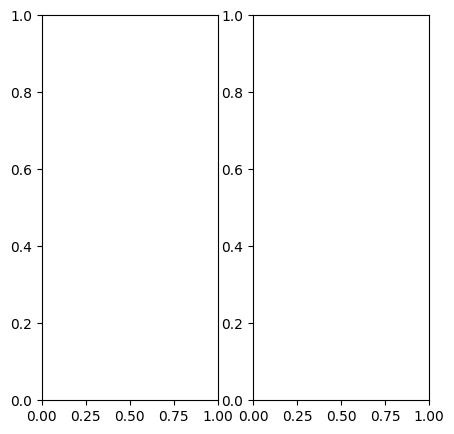

In [37]:
# # Calculate the number of rows and columns based on the total number of images
# num_cols = 8
# num_rows = (tot) // (num_cols) + 1

# # Set the size of each individual subplot
# fig_width = 15  # Adjust this value to control the width of each subplot
# fig_height = 15  # Adjust this value to control the height of each subplot

# # Create subplots with adjusted figsize
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * fig_width, num_rows * fig_height))

fig,axs = plt.subplots(1,2, figsize=(5,5))

# Initialize a counter for the subplot index
i = 0

# Iterate over categories
show_cat = ['moon']
for OBcat in show_cat:
    # Iterate over images in the category
    for item in range(0, len(picname_per_cat[OBcat])):
        # Get the subplot corresponding to the current index
        ax = axs[i // num_cols, i % num_cols]

        # # Load and display the image
        # jpg_path = "/content/drive/MyDrive/DLiP/oracle_bone/image/" + picname_per_cat[OBcat][item]
        # _, strokes, _ = image_to_lines(jpg_path)
        img = convert_to_PIL(rs_strk[OBcat][item])

        # Make sure img is a NumPy array with a numeric dtype
        img = np.asarray(img, dtype=np.uint8)

        ax.set_title(OBcat, fontsize=4)
        ax.imshow(img, cmap='gray', aspect='auto')  # Use aspect='auto' to allow non-square images
        ax.axis('off')

        # Increment the subplot index
        i += 1

# Hide empty subplots
for j in range(i, num_rows * num_cols):
    axs[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()


In [30]:
show_cat = ['bird']
for i in show_cat:
  print(i)



bird


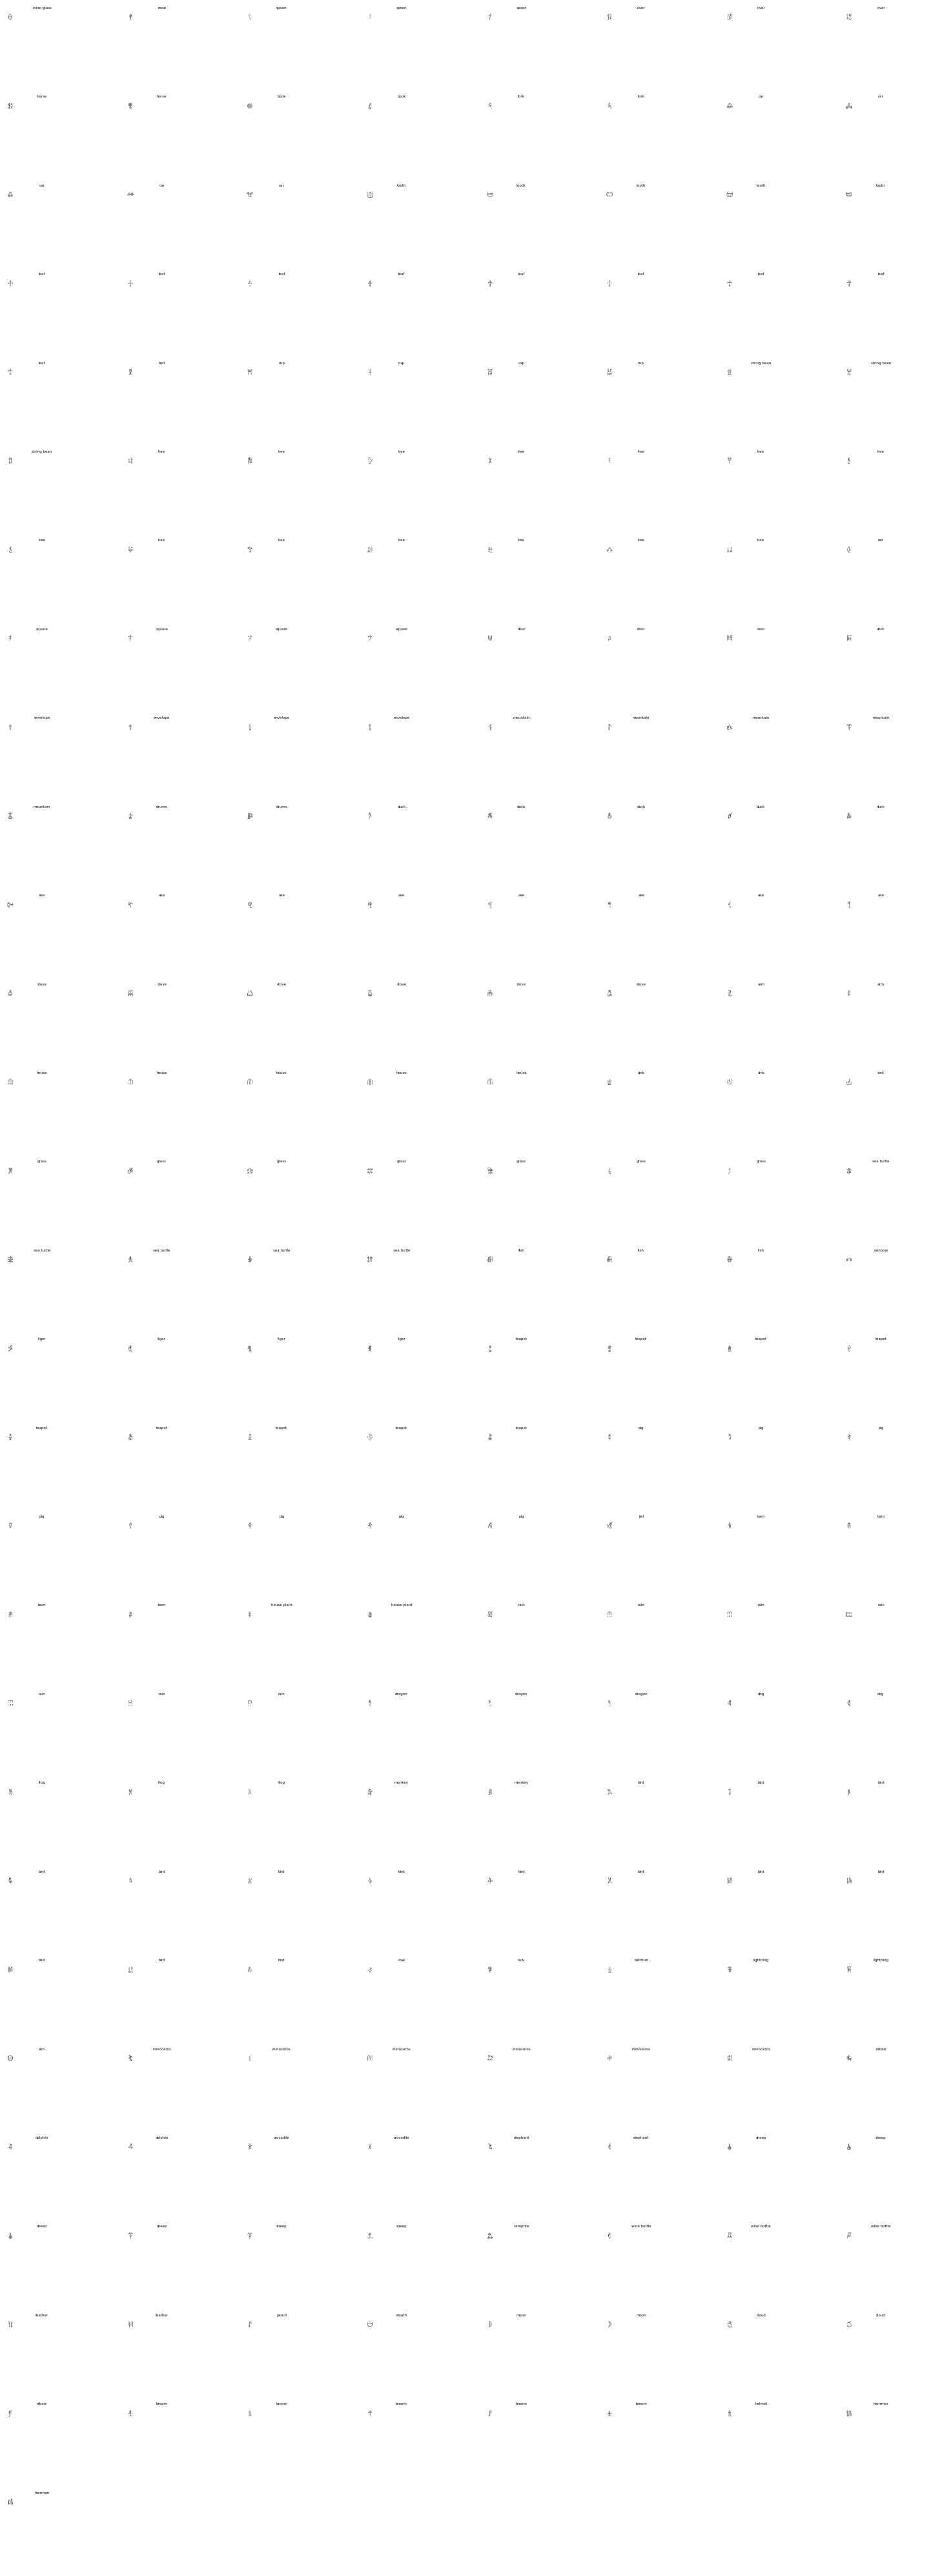

In [20]:

# Calculate the number of rows and columns based on the total number of images
num_cols = 8
num_rows = (tot) // (num_cols) + 1

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 40))

# Initialize a counter for the subplot index
i = 0

# Iterate over categories
for OBcat in OBcats:
    # Iterate over images in the category
    for item in range(0, len(picname_per_cat[OBcat])):
        # Get the subplot corresponding to the current index
        ax = axs[i // num_cols, i % num_cols]

        # Load and display the image
        jpg_path = "/content/drive/MyDrive/DLiP/oracle_bone/image/" + picname_per_cat[OBcat][item]
        _,strokes,_ = image_to_lines(jpg_path)
        img = convert_to_PIL(strokes)

        # Make sure img is a NumPy array with a numeric dtype
        img = np.asarray(img, dtype=np.uint8)

        ax.set_title(OBcat, fontsize=4)
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        # Increment the subplot index
        i += 1

# Hide empty subplots
for j in range(i, num_rows * num_cols):
    axs[j // num_cols, j % num_cols].axis('off')

plt.tight_layout()
plt.show()


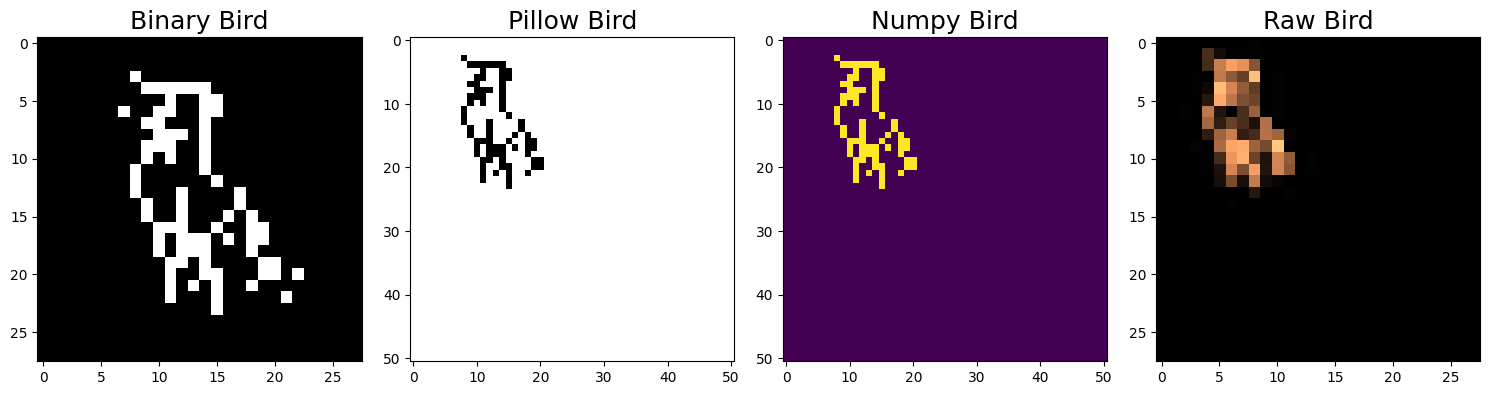

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

bird_lin,bird_stroke,_ = image_to_lines("/content/drive/MyDrive/DLiP/oracle_bone/image/" + picname_per_cat['bird'][3])


axs[0].imshow(bird_lin, cmap = 'bone')
axs[0].set_title('Binary Bird', fontsize = 18)


pil_bird = OBconvert_to_PIL(bird_stroke)
axs[1].imshow(pil_bird)
axs[1].set_title('Pillow Bird', fontsize = 18)


np_bird = convert_to_np(pil_bird, width = 51, height = 51)
axs[2].imshow(np_bird)
axs[2].set_title('Numpy Bird', fontsize = 18)


raw_bird = OBconvert_to_np_raw(bird_stroke, width = 51, height = 51)
axs[3].imshow(raw_bird, cmap = 'copper')
axs[3].set_title('Raw Bird', fontsize = 18)

plt.tight_layout()

In [48]:
# Shrinking the images, similar to the quickdraw data.

OBvals_dict = {}

for OBcat in OBcats:
  OBdat = OBdict[OBcat]
  # OBvals = [OBconvert_to_np_raw(OBimg, width = 51, height = 51).reshape(1, 784) for OBimg in np.array(OBdict[OBcat]['bonescript'])]
  OBvals = [OBconvert_to_np_raw(OBimg, width = 28, height = 28).reshape(1, 784) for OBimg in np.array(OBdict[OBcat]['bonescript'])]
  OBvals_dict[OBcat] = OBvals

OBX = []
OBy = []

for key, value in label_dict.items():
    data_i = OBvals_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()

    OBX.append(Xi)
    OBy.append(yi)

OBX = np.concatenate(OBX, axis = 0)
OBy = np.concatenate(OBy, axis = 0)



In [49]:
print(OBX.shape)

(225, 784)


In [50]:
# shrinking the images

# create the dictionary containing classes names as keys and images as values
values_dict = {}
for category in categories:
    data = classes[category][:500]
    values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    values_dict[category] = values

# concatenate to create X (values) and y (labels) datasets
X = []
y = []

for key, value in label_dict.items():
    data_i = values_dict[value]
    Xi = np.concatenate(data_i, axis = 0)
    yi = np.full((len(Xi), 1), key).ravel()

    X.append(Xi)
    y.append(yi)

X = np.concatenate(X, axis = 0)
y = np.concatenate(y, axis = 0)

In [ ]:
print(X.shape)

# You can skip this for now. Only plots heatmaps. Don't delete

In [ ]:
import random
import matplotlib.pyplot as plt

def view_images_grid(X, y):
    """
    Function to plot a grid with several examples of images.
    INPUT:
        X - (numpy array) images dataset
        y - (numpy array) labels for images from X dataset

    OUTPUT: None
    """
    fig, axs = plt.subplots(10, 5, figsize=(15, 20), dpi=100)

    for label_num in range(0, 50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28, 28)  # reshape images
        i = label_num // 5
        j = label_num % 5
        axs[i, j].imshow(image, cmap='binary', aspect='auto')  # plot the data
        axs[i, j].axis('off')
        axs[i, j].set_title(label_dict[y[r_label]], fontsize=8, loc="center")

    plt.show()

# Assuming label_dict is defined elsewhere in your code
# label_dict = {0: 'Label_0', 1: 'Label_1', 2: 'Label_2', ...}

# Example usage:
# view_images_grid(X, y)


# Also skip this one for now. Doesn't work well and not crucial. I'll fix this later, so don't delete

In [ ]:
def view_images_grid(X, y):
    """
    Function to plot grid with several examples of images.
    INPUT:
        X - (numpy array) images dataset
        y - (numpy array) labels for images from X dataset

    OUTPUT: None
    """
    fig, axs = plt.subplots(10, 5, figsize=(10,10), dpi = 100)

    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 5
        j = label_num % 5
        axs[i,j].imshow(image, cmap = 'binary') #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[y[r_label]], fontsize = 5, loc = "center")

    plt.show()

We can try to make these two grids match regarding categories presented, using random.seed(). However, as OBX and X are different sizes, this doesn't work yet. You'd need to go back to the labeled dicts.

# Don't run, don't delete

In [51]:
# random.seed(10)
view_images_grid(OBX, OBy)

NameError: ignored

# Don't run don't delete

In [ ]:
# random.seed(10)
view_images_grid(X, y)

In [ ]:
def get_label_heatmap(X, y, label, label_name):
    """
    Function to plot the heatmap for images with same label.
    INPUT:
        X - (numpy array) dataset
        y - (numpy array) labels for X dataset
        label - (int) label for images
        label_name - (str) name for images label

    OUTPUT: None
    """
    # filter X_train to remove all other images
    label_filter = y == label
    X = pd.DataFrame(X)
    X_labeled = X[label_filter]

    # find mean value for pixels
    X_mean = np.sum(X_labeled, axis = 0).values

    return X_mean

# don't run don't delete

In [ ]:
# Plot the heatmaps per category of the QuickDraw dataset.

total_plots = len(label_dict)

# Calculate the number of rows and columns based on the total number of subplots
num_rows = (total_plots - 1) // 8 + 1
num_cols = min(total_plots, 8)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over label_dict items
for idx, (key, value) in enumerate(label_dict.items()):
    # get heatmap
    heatmap = get_label_heatmap(X, y, key, value)

    # Calculate the subplot position
    i = idx // 8
    j = idx % 8

    # plot image
    axs[i, j].set_title(value, fontsize = 10)
    axs[i, j].imshow(heatmap.reshape(28, 28).squeeze(), cmap='bone')
    axs[i, j].axis('off')

# Hide empty subplots
for idx in range(len(label_dict), num_rows * num_cols):
    axs[idx // 8, idx % 8].axis('off')

plt.tight_layout()
plt.show()


# also don't run don't delete

In [ ]:
# Heatmaps for Oracle Bone Dataset.

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over label_dict items
for idx, (key, value) in enumerate(label_dict.items()):
    # get heatmap
    heatmap = get_label_heatmap(OBX, OBy, key, value)

    # Calculate the subplot position
    i = idx // 8
    j = idx % 8

    # plot image
    axs[i, j].set_title(value, fontsize = 10)
    axs[i, j].imshow(heatmap.reshape(28, 28).squeeze(), cmap='bone') # Ideal cmap
    axs[i, j].axis('off')

# Hide empty subplots
for idx in range(len(label_dict), num_rows * num_cols):
    axs[idx // 8, idx % 8].axis('off')

plt.tight_layout()
plt.show()


# This one you need to run, here we define the model and functions related to its performance.

In [52]:
def build_model(input_size, output_size, hidden_sizes, dropout = 0.0):
    '''
    Function creates deep learning model based on parameters passed.

    INPUT:
        input_size, output_size, hidden_sizes - layer sizes
        dropout - dropout (probability of keeping a node)

    OUTPUT:
        model - deep learning model
    '''

    # Build a feed-forward network
    model = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                          ('relu1', nn.ReLU()),
                          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                          ('bn2', nn.BatchNorm1d(num_features=hidden_sizes[1])),
                          ('relu2', nn.ReLU()),
                          ('dropout', nn.Dropout(dropout)),
                          ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                          ('bn3', nn.BatchNorm1d(num_features=hidden_sizes[2])),
                          ('relu3', nn.ReLU()),
                          ('logits', nn.Linear(hidden_sizes[2], output_size))]))

    return model

def shuffle(X_train, y_train):
    """
    Function which shuffles training dataset.
    INPUT:
        X_train - (tensor) training set
        y_train - (tensor) labels for training set

    OUTPUT:
        X_train_shuffled - (tensor) shuffled training set
        y_train_shuffled - (tensor) shuffled labels for training set
    """
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled


def fit_model(model, X_train, y_train, epochs=100, n_chunks=1000, learning_rate=0.003, weight_decay=0, optimizer='SGD'):
    """
    Function which fits the model.

    INPUT:
        model - pytorch model to fit
        X_train - (tensor) train dataset
        y_train - (tensor) train dataset labels
        epochs - number of epochs
        n_chunks - number of chunks to split the dataset
        learning_rate - learning rate value

    OUTPUT: None
    """

    print("Fitting model with epochs = {epochs}, learning rate = {lr}\n".format(epochs=epochs, lr=learning_rate))

    criterion = nn.CrossEntropyLoss()

    if optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    print_every = 10

    steps = 0

    for e in range(epochs):
        running_loss = 0

        # Shuffle the training data before each epoch
        permutation = torch.randperm(X_train.size(0))
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, len(X_train_shuffled), n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            images = X_train_shuffled[i:i + n_chunks]
            labels = y_train_shuffled[i:i + n_chunks]
            output = model.forward(images)
            loss = criterion(output, labels.squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if epochs % print_every == 0:
            print("Epoch: {}/{}... ".format(e + 1, epochs),
                  "Loss: {:.4f}".format(running_loss / print_every))

            running_loss = 0



def view_classify(img, ps):
    """
    Function for viewing an image and it's predicted classes
    with matplotlib.

    INPUT:
        img - (tensor) image file
        ps - (tensor) predicted probabilities for each class
    """
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(ncats), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(ncats))
    ax2.set_yticklabels(OBcats, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

def test_model(model, img):
    """
    Function creates test view of the model's prediction for image.

    INPUT:
        model - pytorch model
        img - (tensor) image from the dataset

    OUTPUT: None
    """

    # Convert 2D image to 1D vector
    img = img.resize_(1, 784)

    ps = get_preds(model, img)
    view_classify(img.resize_(1, 28, 28), ps)

def get_preds(model, input):
    """
    Function to get predicted probabilities from the model for each class.

    INPUT:
        model - pytorch model
        input - (tensor) input vector

    OUTPUT:
        ps - (tensor) vector of predictions
    """

    # Turn off gradients to speed up this part
    with torch.no_grad():
        logits = model.forward(input)
    ps = F.softmax(logits, dim=1)
    return ps

def get_labels(pred):
    """
        Function to get the vector of predicted labels for the images in
        the dataset.

        INPUT:
            pred - (tensor) vector of predictions (probabilities for each class)
        OUTPUT:
            pred_labels - (numpy) array of predicted classes for each vector
    """

    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

def evaluate_model(model, train, y_train, test, y_test):
    """
    Function to print out train and test accuracy of the model.

    INPUT:
        model - pytorch model
        train - (tensor) train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset

    OUTPUT:
        accuracy_train - accuracy on train dataset
        accuracy_test - accuracy on test dataset
    """
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {} \n".format(accuracy_train))
    print("Accuracy score for test set is {} \n".format(accuracy_test))

    return accuracy_train, accuracy_test



def plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate=0.003, weight_decay=0.0, dropout=0.0, n_chunks=1000, optimizer='SGD'):
    """
    Function to plot learning curve depending on the number of epochs.

    INPUT:
        input_size, output_size, hidden_sizes - model parameters
        train - (tensor) train dataset
        labels - (tensor) labels for train dataset
        y_train - (numpy) labels for train dataset
        test - (tensor) test dataset
        y_test - (numpy) labels for test dataset
        learning_rate - learning rate hyperparameter
        weight_decay - weight decay (regularization)
        dropout - dropout for hidden layer
        n_chunks - the number of minibatches to train the model
        optimizer - optimizer to be used for training (SGD or Adam)

    OUTPUT: None
    """
    train_acc = []
    test_acc = []

    for epochs in range(10, 200, 10):
        # create model
        model = build_model(input_size, output_size, hidden_sizes, dropout=dropout)

        # fit model
        fit_model(model, train, labels, epochs=epochs, n_chunks=n_chunks, learning_rate=learning_rate, weight_decay=weight_decay, optimizer='SGD')
        # get accuracy
        accuracy_train, accuracy_test = evaluate_model(model, train, y_train, test, y_test)

        train_acc.append(accuracy_train)
        test_acc.append(accuracy_test)

    return train_acc, test_acc


Here we split the QuickDraw dataset into a test and train part. As we won't test it on the QuickDraw, it's somewhat trivial, but we still need to have the X_train and y_train variables so you need to run it still.

In [54]:
# Split dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

This is where we assign the test and training set we'll use for the out-of-sample test = train on QuickDraw, test on Oracle Bone. Also involves some of the hyperparameters we can play around with. Make sure the input_size ,hidden_sizes, and output_size correspond with what we put into the model.

In [55]:
# Preparations for train on QD, test on OB

# Convert to tensors
train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()
OBtest = torch.from_numpy(OBX).float()
OBtest_labels = torch.from_numpy(OBy).long()

# Set hyperparameters for our network
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 64


dropout = 0.0
weight_decay = 0.0
n_chunks = 700
learning_rate = 0.02
optimizer = 'SGD'

Here we build the model and fit it, followed by the loss scores per 10 epochs and intermediate test/train accuracy scores. This takes a while, depending on your hyperparameters.

In [ ]:
# Build model
model = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

# Fit model
OBtrain_acc, OBtest_acc = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, OBtest, OBy, learning_rate = learning_rate, dropout = dropout, weight_decay = weight_decay, n_chunks = n_chunks, optimizer = optimizer)

This is where the test/train variables are assigned for

In [ ]:
# QD on QD classifier

# Convert to tensors
train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()
test = torch.from_numpy(X_test).float()
test_labels = torch.from_numpy(y_test).long()

# Set hyperparameters for our network
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 64

dropout = 0.0
weight_decay = 0.0
n_chunks = 700
learning_rate = 0.03
optimizer = 'SGD'

In [ ]:
# Build model
model = build_model(input_size, output_size, hidden_sizes, dropout = dropout)

# Fit model
train_acc, test_acc = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = learning_rate, dropout = dropout, weight_decay = weight_decay, n_chunks = n_chunks, optimizer = optimizer)

In [ ]:
# Plot curve
x = np.arange(10, 10 * (len(OBtrain_acc) + 1), 10)
plt.plot(x, OBtrain_acc)
plt.plot(x, OBtest_acc)
plt.legend(['train', 'OBtest'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

In [ ]:
# Plot curve
x = np.arange(10, 10 * (len(train_acc) + 1), 10)
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

In [ ]:
# Build new ones of this. That work for the OB dat.

def convert_to_PIL_from_np(img):
    """
    Function to convert numpy (1, 784) image to PIL image.
    INPUT:
        img - (numpy array) image from train dataset with size (1, 784)
    OUTPUT:
        pil_img - (PIL Image) 28x28 image
    """
    img_r = img.reshape(28,28)

    pil_img = Image.new('RGB', (28, 28), 'white')
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            if img_r[i, j] > 0:
                pixels[j, i] = (255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255))

    return pil_img

def OBconvert_to_PIL_from_np(img):
    """
    Function to convert numpy (1, 784) image to PIL image.
    INPUT:
        img - (numpy array) image from train dataset with size (1, 784)
    OUTPUT:
        pil_img - (PIL Image) 28x28 image
    """
    img_r = img.reshape(28,28)

    pil_img = Image.new('RGB', (28, 28), 'white')
    pixels = pil_img.load()

    for i in range(0, 28):
        for j in range(0, 28):
            if img_r[i, j] > 0:
                pixels[j, i] = (255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255), 255 - int(img_r[i, j] * 255))

    return pil_img

def add_flipped_and_rotated_images(X_train, y_train):
    """
    Function which adds flipped and rotated images to the original dataset.
    INPUT:
        X_train - (numpy array) the original training set
        y_train - (numpy array) original labels dataset
    OUTPUT:
        X_Train_new - (numpy array) the dataset with added flipped and rotated
        images
        y_train_new - (numpy array) labels for the new training dataset
    """
    print("Adding flipped and rotated images to the training set. \n")

    X_train_new = X_train.copy()
    y_train_new = y_train.copy().reshape(y_train.shape[0], 1)

    for i in range(0, X_train.shape[0], 10): # I will skip some images just to run this faster
        # get image to rotate and flip
        img = X_train[i]
        pil_img = convert_to_PIL_from_np(img)

        # get random angle
        angle = random.randint(5, 10)

        # rotate and flip
        rotated = convert_to_np(rotate_image(pil_img, angle), 28, 28)
        flipped = convert_to_np(flip_image(pil_img), 28, 28)

        # add to the original dataset
        X_train_new = np.append(X_train_new, rotated.reshape(1, 784), axis = 0)
        X_train_new = np.append(X_train_new, flipped.reshape(1, 784), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)

        # print out progress
        if i % 1000 == 0:
            print("Processed {i} files out of {total}.".format(i= i, total = X_train.shape[0]))

    return X_train_new, y_train_new

def OBadd_flipped_and_rotated_images(X_train, y_train):
    """
    Function which adds flipped and rotated images to the original dataset.
    INPUT:
        X_train - (numpy array) the original training set
        y_train - (numpy array) original labels dataset
    OUTPUT:
        X_Train_new - (numpy array) the dataset with added flipped and rotated
        images
        y_train_new - (numpy array) labels for the new training dataset
    """
    print("Adding flipped and rotated images to the training set. \n")

    X_train_new = X_train.copy()
    y_train_new = y_train.copy().reshape(y_train.shape[0], 1)

    for i in range(0, OBX.shape[0], 1): # I will skip some images just to run this faster
        # get image to rotate and flip
        img = X_train[i]
        pil_img = convert_to_PIL_from_np(img)

        # get random angle
        angle = random.randint(5, 10)

        # rotate and flip
        rotated = convert_to_np(rotate_image(pil_img, angle), 28, 28)
        flipped = convert_to_np(flip_image(pil_img), 28, 28)

        # add to the original dataset
        X_train_new = np.append(X_train_new, rotated.reshape(1, 784), axis = 0)
        X_train_new = np.append(X_train_new, flipped.reshape(1, 784), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)
        y_train_new = np.append(y_train_new, y_train[i].reshape(1,1), axis = 0)

        # print out progress
        if i % 1000 == 0:
            print("Processed {i} files out of {total}.".format(i= i, total = X_train.shape[0]))

    return X_train_new, y_train_new

In [ ]:
# examples of flipped and rotated images
fig, axs = plt.subplots(1,3, figsize=(6,3))

np_img = X[0]
np_img_flipped = convert_to_np(flip_image(convert_to_PIL_from_np(np_img)), 28, 28)
np_img_rotated = convert_to_np(rotate_image(convert_to_PIL_from_np(np_img)), 28, 28)

# plot the original image
axs[0].set_title('original image')
axs[0].imshow(np_img.reshape(28, 28).squeeze())
axs[0].axis('off')

# plot the flipped image
axs[1].set_title('flipped image')
axs[1].imshow(np_img_flipped.reshape(28, 28).squeeze())
axs[1].axis('off')

# plot the rotated image
axs[2].set_title('rotated image')
axs[2].imshow(np_img_rotated.reshape(28, 28).squeeze())
axs[2].axis('off')

In [ ]:
# import math

# # print(convert_to_np(flip_image(convert_to_PIL_from_np(X[0])), 28, 28))

a = (np.log(OBX[0]+5.1))
# # print(math.log(OBX[0]+4.1))

# o = OBX[0]+4.1
# print(np.log(OBX[0]))



In [ ]:
print(convert_to_np(rotate_image(convert_to_PIL_from_np(a)), 28, 28))


# print(normalize(convert_to_PIL_from_np(OBX[0])),28, 28)
# print(OBX[0])

# print(normalize(OBX[0])+4.1)
a = OBX[0]+4.1
# print(OBX[0]+4.1)



In [ ]:
# examples of flipped and rotated images
fig, axs = plt.subplots(1,3, figsize=(6,3))

np_img = OBX[0]
np_img = a
np_img_flipped = convert_to_np(flip_image(convert_to_PIL_from_np(np_img)), 28, 28)
np_img_rotated = convert_to_np(rotate_image(convert_to_PIL_from_np(np_img)), 28, 28)

# plot the original image
axs[0].set_title('original image')
axs[0].imshow(np_img.reshape(28, 28).squeeze())
axs[0].axis('off')

# plot the flipped image
axs[1].set_title('flipped image')
axs[1].imshow(np_img_flipped.reshape(28, 28).squeeze())
axs[1].axis('off')

# plot the rotated image
axs[2].set_title('rotated image')
axs[2].imshow(np_img_rotated.reshape(28, 28).squeeze())
axs[2].axis('off')

In [ ]:
X_train, y_train = add_flipped_and_rotated_images(X_train, y_train)

In [ ]:
train = torch.from_numpy(X_train).float()
labels = torch.from_numpy(y_train).long()

# Fit model
train_acc, test_acc = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, OBtest, OBy, learning_rate = learning_rate, dropout = dropout, weight_decay = weight_decay, n_chunks = 400, optimizer = optimizer)

In [ ]:
# Plot curve
x = np.arange(10, 10 * (len(train_acc) + 1), 10)
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

In [ ]:
# Fit model
train_acc, test_acc = plot_learning_curve(input_size, output_size, hidden_sizes, train, labels, y_train, test, y_test, learning_rate = learning_rate, dropout = 0.2, weight_decay = weight_decay, n_chunks = 400, \
                                          optimizer = 'Adam')

In [ ]:
# Plot curve
x = np.arange(10, 10 * (len(train_acc) + 1), 10)
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=14)
plt.xlabel('Number of epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.show()

In [ ]:
# turn off batch normalization
model.eval()

# get prediction for the image from the test dataset
test_model(model, test[45])

**ORACLE BONE PART**

In [ ]:
# cd PROJECT_DIR
git clone https://github.com/cuicaihao/deep-learning-for-oracle-bone-script-recognition
# or
# gh repo clone cuicaihao/deep-learning-for-oracle-bone-script-recognition

In [ ]:
# -*- coding: utf-8 -*-
import click
import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from src.data.make_dataloader import create_dataloader, show_oracle_character

import os
import sys
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")
# plt.ion()  # interactive mode
sys.path.append(os.path.dirname(os.path.realpath(__file__)))
print(os.path.dirname(os.path.realpath(__file__)))


def show_loader_batch(dataloader):
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['label'].size())
        plt.figure(figsize=(10, 10))
        show_oracle_character(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        if i_batch == 0:
            break


def test_loader_function(root_dir, csv_file):

    training_loader, dataset = create_dataloader(csv_file,
                                                 root_dir,
                                                 batch_size=16,
                                                 rescale_size=45,
                                                 randomcrop_size=40)

    validation_loader, dataset = create_dataloader(csv_file,
                                                   root_dir,
                                                   batch_size=16,
                                                   rescale_size=45,
                                                   randomcrop_size=40,
                                                   datatype='validation')

    show_loader_batch(training_loader)
    show_loader_batch(validation_loader)



# defining the model architecture
class Net(nn.Module):

    def __init__(self, class_number):
        super(Net, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # a. half-of-size

            # Defining another 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # a. half-of-size
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(64 * 5 * 5, class_number)  # 793
        )

    # Defining the forward pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


def run_main(root_dir, csv_file, label_name_file, output_dir):

    # root_dir='./data/raw/image/'
    # csv_file="./data/processed/image_name_label.csv"
    # label_name_file="./data/processed/label_name.csv"
    # output_dir="./models"

    training_loader, dataset = create_dataloader(csv_file,
                                                 root_dir,
                                                 batch_size=16,
                                                 rescale_size=45,
                                                 randomcrop_size=40)
    validation_loader, dataset = create_dataloader(csv_file,
                                                   root_dir,
                                                   batch_size=16,
                                                   rescale_size=45,
                                                   randomcrop_size=40,
                                                   datatype='validation')

    # get total class number
    label2name_frame = pd.read_csv(label_name_file)
    class_number = len(label2name_frame)
    # defining the model
    model = Net(class_number)
    # defining the loss function
    loss_fn = nn.CrossEntropyLoss()
    # defining the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter(output_dir + '/runs/obs_{}'.format(timestamp))
    epoch_number = 0
    EPOCHS = 200
    best_vloss = 10.
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        running_loss = 0.
        last_loss = 0.
        # Here, we use enumerate(training_loader) instead of
        # iter(training_loader) so that we can track the batch
        # index and do some intra-epoch reporting
        for i, data in enumerate(training_loader):
            # Every data instance is an input + label pair
            inputs = data['image'].float()
            labels = data['label'].long()
            # inputs = Variable(inputs)

            # Zero your gradients for every batch!
            optimizer.zero_grad()

            # Make predictions for this batch
            outputs = model(inputs)

            # Compute the loss and its gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            running_loss += loss.item()
            # 1602/16 = 100 reports on the loss for every 25 batches.
            if i % 100 == 99:
                last_loss = running_loss / 100  # loss per batch
                print('  batch {} loss: {}'.format(i + 1, last_loss))
                tb_x = epoch * len(training_loader) + i + 1
                writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.
                writer.add_images('mage_batch', inputs, epoch)
        avg_loss = last_loss

        # We don't need gradients on to do reporting
        model.train(False)
        running_vloss = 0.0
        for i, vdata in enumerate(validation_loader):
            vinputs = vdata['image'].float()
            vlabels = vdata['label'].long()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss', {
            'Training': avg_loss,
            'Validation': avg_vloss
        }, epoch_number + 1)
        writer.flush()
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            model_path = Path(output_dir) / 'model_best.pt'
            torch.save(model.state_dict(), str(model_path))
            writer.add_graph(model, vinputs)
        writer.flush()
        epoch_number += 1

    # Check the Final best model performance
    correct_count, all_count = 0, 0
    for data in validation_loader:
        images = data['image'].float()
        labels = data['label'].long()
        for i in range(len(labels)):
            # img = images[i].view(1, 1, 28, 28)
            img = images[i, :, :, :]
            img = torch.unsqueeze(img, dim=0)
            with torch.no_grad():
                logps = model(img)
            # ps = torch.exp(logps)
            # probab = list(ps.cpu()[0])
            pred_label = logps.argmax(1).item()
            true_label = labels.cpu()[i]
            if (true_label == pred_label):
                correct_count += 1
            all_count += 1

    print("Number Of Images =", all_count)
    print("\nModel Accuracy =", (correct_count / all_count))

    return True


@click.command()
@click.argument('input_image_filepath', type=click.Path(exists=True))
@click.argument('input_label_filepath', type=click.Path())
@click.argument('input_label_name_filepath', type=click.Path())
@click.argument('output_model_filepath', type=click.Path())
def main(input_image_filepath, input_label_filepath, input_label_name_filepath,
         output_model_filepath):
    """ Runs data processing scripts to turn raw data from (../raw) into
        cleaned data ready to be analyzed (saved in ../processed).
    """
    logger = logging.getLogger(__name__)
    logger.info('image_dir: {}'.format(input_image_filepath))
    logger.info('image_labe_dir: {}'.format(input_label_filepath))
    logger.info('image_label_name_dir: {}'.format(input_label_name_filepath))
    logger.info('output_model_filepath: {}'.format(output_model_filepath))

    # check the image
    # test_loader_function(input_image_filepath, input_label_filepath) # PASS
    run_main(input_image_filepath, input_label_filepath,
             input_label_name_filepath, output_model_filepath)


if __name__ == '__main__':
    log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    logging.basicConfig(level=logging.INFO, format=log_fmt)

    # not used in this stub but often useful for finding various files
    project_dir = Path(__file__).resolve().parents[2]

    # find .env automagically by walking up directories until it's found, then
    # load up the .env entries as environment variables
    load_dotenv(find_dotenv())
    main()
